In [1]:
import random
from collections import OrderedDict, defaultdict

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

To ensure the reproducibility, we will control the seed of random generators:

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

## Data

In this tutorial, we will use CIFAR-10 as our target dataset. This dataset contains images from 10 classes, where each image is of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [4]:
transforms = {
  "train": Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
  ]),
  "test": ToTensor(),
}

dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:17<00:00, 9.48MB/s]


We can visualize a few images in the dataset and their corresponding class labels:

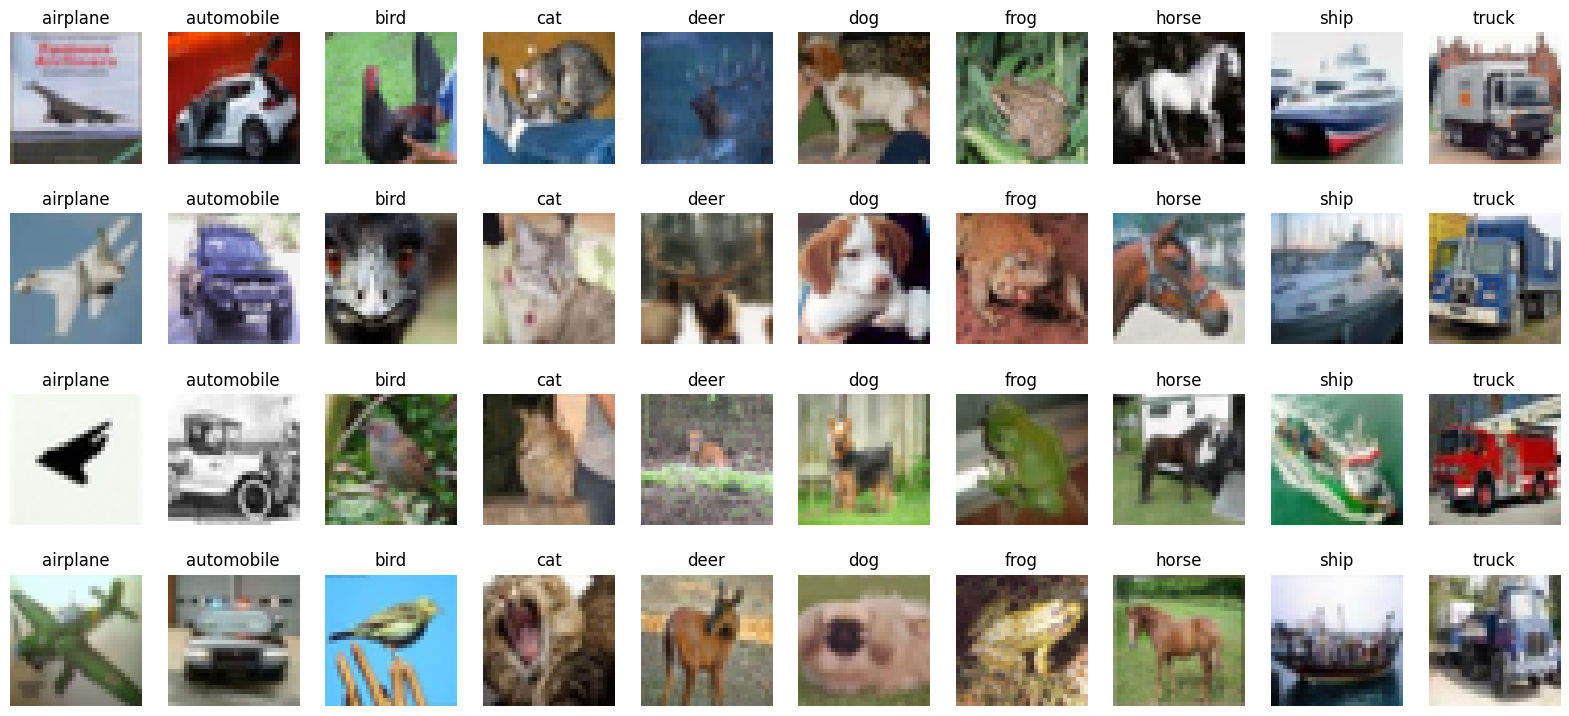

In [5]:
samples = [[] for _ in range(10)]
for image, label in dataset["test"]:
  if len(samples[label]) < 4:
    samples[label].append(image)

plt.figure(figsize=(20, 9))
for index in range(40):
  label = index % 10
  image = samples[label][index // 10]

  # Convert from CHW to HWC for visualization
  image = image.permute(1, 2, 0)

  # Convert from class index to class name
  label = dataset["test"].classes[label]

  # Visualize the image
  plt.subplot(4, 10, index + 1)
  plt.imshow(image)
  plt.title(label)
  plt.axis("off")
plt.show()

To train a neural network, we will need to feed data in batches. We create data loaders with batch size of 512:

In [6]:
dataflow = {}
for split in ['train', 'test']:
  dataflow[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

We can print the data type and shape from the training data loader:

In [7]:
for inputs, targets in dataflow["train"]:
  print("[inputs] dtype: {}, shape: {}".format(inputs.dtype, inputs.shape))
  print("[targets] dtype: {}, shape: {}".format(targets.dtype, targets.shape))
  break

[inputs] dtype: torch.float32, shape: torch.Size([512, 3, 32, 32])
[targets] dtype: torch.int64, shape: torch.Size([512])


## Model

In this tutorial, we will use a variant of VGG-11 (with fewer downsamples and a smaller classifier) as our model.

In [ ]:
# PyTorch의 모든 신경망 모델의 기본 클래스인 nn.Module을 상속받아 VGG라는 새로운 모델 클래스를 정의
class VGG(nn.Module):
    # ARCH = [...]: 이 모델의 구조(Architecture)를 정의하는 청사진
    # 숫자 (e.g., 64, 128, ...): nn.Conv2d (합성곱) 레이어의 출력 채널(output channel) 수를 의미합니다. 즉, 사용할 필터의 개수 (필터 하나당 한 개의 output channel을 만든다)
    # 'M': nn.MaxPool2d (맥스 풀링) 레이어를 의미
    # 피처 맵(feature map)의 크기를 절반으로 줄여(downsampling) 계산량을 줄이고, 중요한 특징을 추출하는 역할
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    # helper 함수인 add 함수
    # pytorch 레이어들은 각각 이름을 가질 수 있다. conv 레이어가 여러 개일 경우 conv0, conv1 , ... 등
    # 덕분에 디버깅이나 모델 구조 파악이 쉬워짐
    # add 함수는 str 타입의 name과 pytorch의 layer 객체(nn.Conv2d, nn.ReLU 등) 이 파라미터로 전달
    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))   # layers 리스트에 (레이어의 이름, 레이어 객체) 튜플을 저장한다.
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    # OrderedDict 는 순서를 보장해준다.
    # nn.Sequential은 pytorch에서 여러 개의 레이어를 담는 컨테이너 역할
    # 데이터가 입력 되었을 때 컨테이너에 담긴 순서대로 레이어를 차례차례 통과
    self.backbone = nn.Sequential(OrderedDict(layers))
    # 모델의 마지막 부분인 classifier를 정의
    # nn.Linear(in_features, out_features) 
    # 최종적으로 10개의 클래스로 모델은 분류한다.
    self.classifier = nn.Linear(512, 10)

  # nn.Module을 상속받는 모든 클래스는 forward 메서드를 구현해야 함
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    # 텐서의 3번재 차원과 4번재 차원의 평균을 계산한다.
    # 총 512개의 채널에서 각각의 채널에 4개의 픽셀 값의 평균을 구한다고 생각하면 된다.
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

model = VGG().cuda()

Its backbone is composed of eight conv-bn-relu blocks interleaved with four maxpool's to downsample the feature map by 2^4 = 16 times:

In [9]:
print(model.backbone)

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

After the feature map is pooled, its classifier predicts the final output with a linear layer:

In [10]:
print(model.classifier)

Linear(in_features=512, out_features=10, bias=True)


As this course focuses on efficiency, we will then inspect its model size and (theoretical) computation cost.

The model size can be estimated by the number of trainable parameters:

In [ ]:
num_params = 0
# param 변수는 하나의 텐서이고 파라미터의 텐서이다.
# param에는 nn.Conv2d, nn.Linear 등 의 파라미터 텐서가 올 수 있다.
for param in model.parameters():
  # 실제로 학습하는 파라미터만 계산한다.
  if param.requires_grad:
    num_params += param.numel()
print("#Params:", num_params)

#Params: 9228362


The computation cost can be estimated by the number of multiply–accumulate operations (MACs) using TorchProfile:

In [ ]:
# dummy 입력 데이터 하나를 처리하는데 드는 MACs 개수
num_macs = profile_macs(model, torch.zeros(1, 3, 32, 32).cuda())
print("#MACs:", num_macs)

#MACs: 606164480


This model has 9.2M parameters and requires 606M MACs for inference. 
We will work together in the next few labs to improve its efficiency.

## Optimization

As we are working on a classification problem, we will apply cross entropy as our loss function to optimize the model:

In [13]:
criterion = nn.CrossEntropyLoss()

Optimization will be carried out using stochastic gradient descent (SGD) with momentum:

In [14]:
optimizer = SGD(
  model.parameters(),
  lr=0.4,
  momentum=0.9,
  weight_decay=5e-4,
)

The learning rate will be modulated using the following scheduler

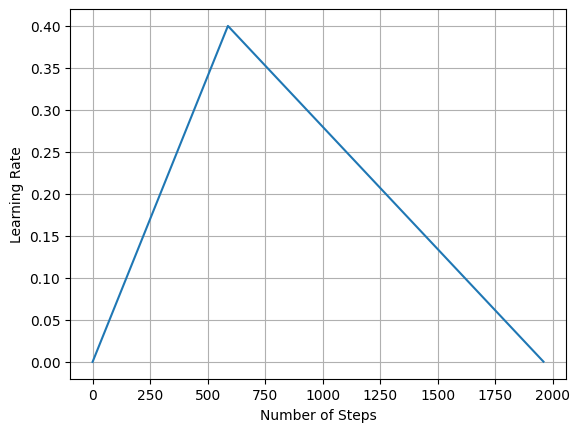

In [ ]:
# learning rate는 loss를 줄이기 위해 모델의 파라미터를 얼마나 크게 업데이트할지를 결정하는 값
num_epochs = 20
steps_per_epoch = len(dataflow["train"])

# Define the piecewise linear scheduler
# np.interp(x, xp, yp) 는 Numpy의 linear interpolation 함수이다.
# xp와 yp로 정의된 점들 사이를 직선으로 잇고, 그 직선 위에서 x에 해당하는 y 값을 찾는다.
lr_lambda = lambda step: np.interp(
  [step / steps_per_epoch],       # 현재 몇 번째 epoch을 진행 중인지를 소수점으로 나타냄
  [0, num_epochs * 0.3, num_epochs],      # learning rate가 변하는 주요 지점을 epoch 단위로 설정, num_epoch이 20이므로 -> 0, 6, 20 번째 epoch이 주요 변곡점
  [0, 1, 0]     # xp의 각 지점에서의 multiplier 값. 이 값은 나중에 optimizer에 설정된 초기 learning rate에 곱해진다.
)[0]

# Visualize the learning rate schedule
# 6번째 epoch에서 임의의 기본 learning rate인 0.4가 되는 것을 확인할 수 있다.(6번째 epoch에서 multiplier가 1이므로 0.4)
# 0부터 6 epoch 까지는 선형적으로 증가하고 다시 20번째 epoch까지 선형적으로 감소하는 것을 확인할 수 있다.
steps = np.arange(steps_per_epoch * num_epochs)
plt.plot(steps, [lr_lambda(step) * 0.4 for step in steps])
plt.xlabel("Number of Steps")
plt.ylabel("Learning Rate")
plt.grid("on")
plt.show()

scheduler = LambdaLR(optimizer, lr_lambda)

## Training

We first define the training function that optimizes the model for one epoch (i.e., a pass over the training set):

In [ ]:
def train(
  model: nn.Module,
  dataflow: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
) -> None:
  # 모델에게 이제 훈련에 들어간다고 알려주는 함수.
  # 일부 layer들은 훈련할때와 추론할 때 다르게 동작하기 때문
  model.train()

  # train 함수가 불러지면 epoch 하나를 학습한다.
  # tqdm은 학습 진행 상황을 시각적으로 보여주는 라이브러리
  # for문 한 번 돌때마다 batch size 크기의 데이터가 처리된다.
  for inputs, targets in tqdm(dataflow, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

We then define the evaluation function that calculates the metric (i.e., accuracy in our case) on the test set:

In [ ]:
# 파이썬의 decorator이다. evaluate 함수 전체를 감싼다.
# torch.inference_mode()는 여기서는 gradient 계산을 하지 마라고 알려줌
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataflow: DataLoader
) -> float:

  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataflow, desc="eval", leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

With training and evaluation functions, we can finally start training the model!

In [18]:
for epoch_num in tqdm(range(1, num_epochs + 1)):
  train(model, dataflow["train"], criterion, optimizer, scheduler)
  metric = evaluate(model, dataflow["test"])
  print(f"epoch {epoch_num}:", metric)

  0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 1: 20.399999618530273


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 2: 49.369998931884766


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 3: 68.30999755859375


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 4: 71.54000091552734


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 5: 51.48999786376953


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 6: 61.21999740600586


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 7: 70.81999969482422


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 8: 72.22999572753906


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 9: 73.93999481201172


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 10: 78.2699966430664


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 11: 68.65999603271484


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 12: 80.2199935913086


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 13: 82.06999969482422


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 14: 84.55000305175781


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 15: 84.58000183105469


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 16: 86.7699966430664


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 17: 89.22999572753906


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 18: 89.79000091552734


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 19: 91.28999328613281


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 20: 92.6199951171875


If everything goes well, your trained model should be able to achieve >92.5% of accuracy!

## Visualization

We can visualize the model's prediction to see how the model truly performs:

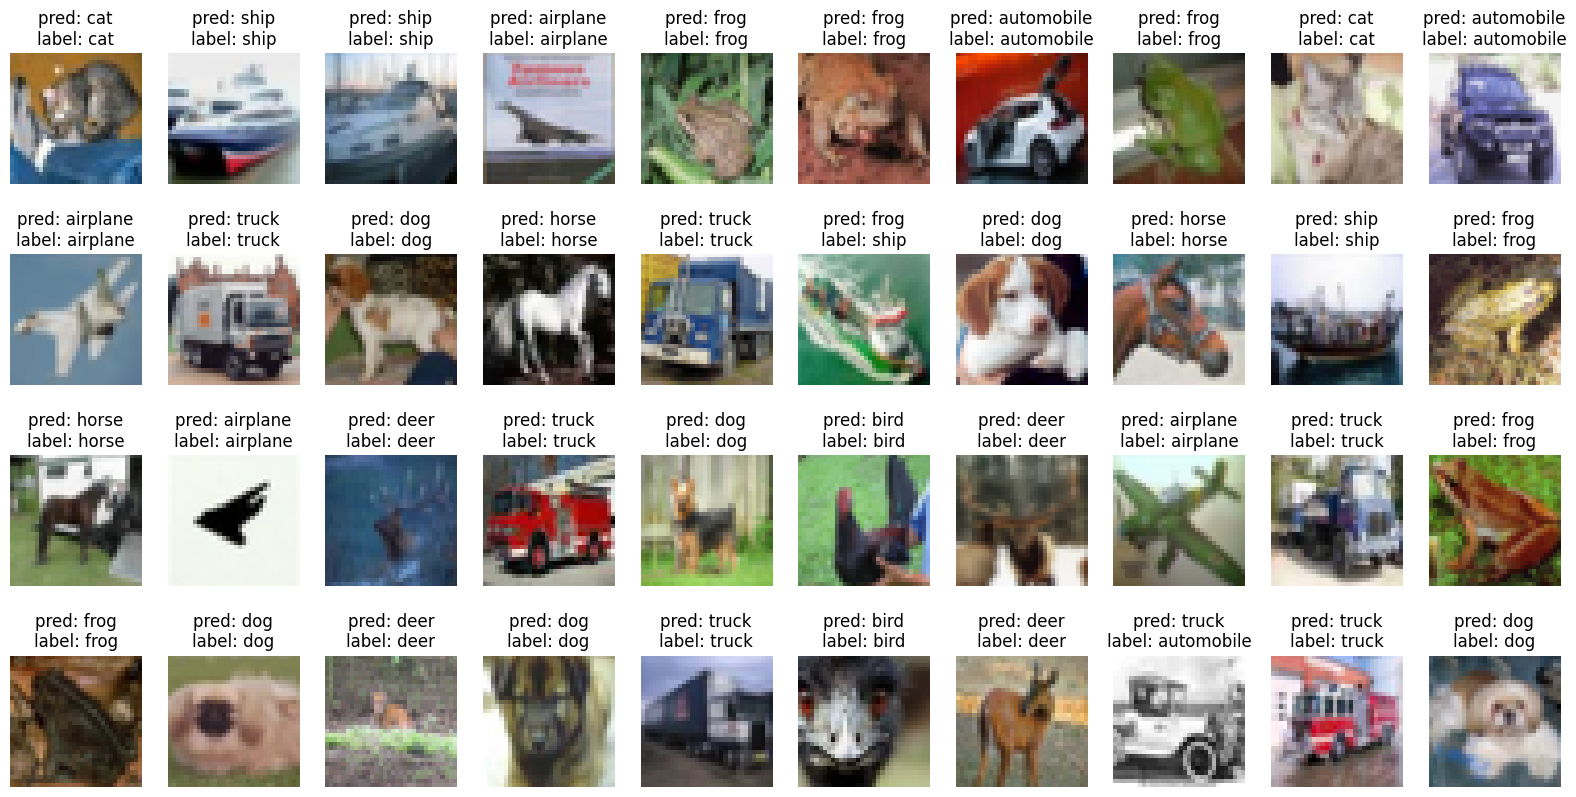

In [19]:
plt.figure(figsize=(20, 10))
for index in range(40):
  image, label = dataset["test"][index]

  # Model inference
  model.eval()
  with torch.inference_mode():
    pred = model(image.unsqueeze(dim=0).cuda())
    pred = pred.argmax(dim=1)

  # Convert from CHW to HWC for visualization
  image = image.permute(1, 2, 0)

  # Convert from class indices to class names
  pred = dataset["test"].classes[pred]
  label = dataset["test"].classes[label]

  # Visualize the image
  plt.subplot(4, 10, index + 1)
  plt.imshow(image)
  plt.title(f"pred: {pred}" + "\n" + f"label: {label}")
  plt.axis("off")
plt.show()